[Differences between image segmentation, classification, and detection](https://www.quora.com/What-is-the-difference-between-image-segmentation-classification-and-detection)


Image segmentation is the task of dividing the image into segments/regions belonging to the same part/object/content.

Image classification is the task of classifying what appears in an image into one out of a set of predefined classes. For example, answering that what appears in an image is a dog.

Detection is the task of localizing where objects are. For example, face detection’s target is to tell where faces are in an image.

Note that image semantic segmentation is the task of classifying each pixel in an image into one out of a set of predefined classes. Such an output yields a segmentation of the image because nearby pixels are often of the same class and hence, such a classification image tends to segment the input.

---------------

Classification can apply to pixels or to images. When classifying pixels, we try to decide whether a given pixel belongs to a particular class

When classifying images, you are trying to identify the type of image you have, such as what the main subject of the picture is (person, dog, bus, building) or whether the image has a particular composition (portrait, landscape, nightscape, cityscape, closeup, etc.) or identifying objects/characters that have been detected and extracted from a larger image (like the MNIST data set).

Generally speaking segmentation transforms the pixels of the image (a raster representation) into a set of outlines or polygons (a vector representation). The vector representation is a more compact description of what is in the image and requires some simplification by the software. For example, in Google Maps the map-view is the vector representation, and the satellite-view is the raster representation. Segmentation requires you to define what attributes or features should be associated with different types of segments - such as roads, forests, cities, water, etc. As Omry pointed out, for segmentation we generally classify the pixels in an image first, and then segment the image by “drawing” an outline around the pixels that belong to the same or similar classes.

In [1]:
'''
CAPSTONE

Initial setup

Ref1:
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

'''

import random
import numpy as np
import matplotlib.pyplot as plt

# Image parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

seed = 64

random.seed = seed
np.random.seed = seed

In [2]:
# Get train and test IDs
import os

train_ids = next(os.walk('stage1_train/'))[1]
test_ids = next(os.walk('stage1_test/'))[1]

print('Number of training ids: {}'.format(len(train_ids)))
print('Number of test ids: {}'.format(len(test_ids)))

Number of training ids: 670
Number of test ids: 65


In [4]:
'''
Get the data
'''

import sys
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = 'stage1_train/' + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = 'stage1_test/' + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')


Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:50<00:00,  6.08it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 41.51it/s]

Done!


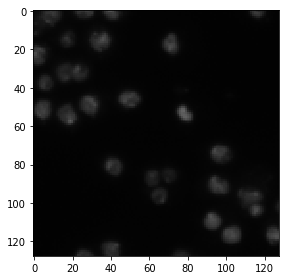

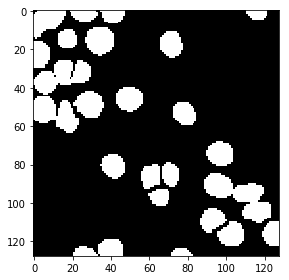

In [5]:
# Check if training data looks all right
from skimage.io import imshow

ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
'''
Intersection Over Union (IoU) Metric

Ref:
https://gist.github.com/meetshah1995/6a5ad112559ef1536d0191f8b9fe8d1e


def computeIoU(y_pred_batch, y_true_batch):
    return np.mean(np.asarray([pixelAccuracy(y_pred_batch[i], y_true_batch[i]) for i in range(len(y_true_batch))])) 

def pixelAccuracy(y_pred, y_true):
    y_pred = np.argmax(np.reshape(y_pred,[N_CLASSES_PASCAL,img_rows,img_cols]),axis=0)
    y_true = np.argmax(np.reshape(y_true,[N_CLASSES_PASCAL,img_rows,img_cols]),axis=0)
    y_pred = y_pred * (y_true>0)
    
    return 1.0 * np.sum((y_pred==y_true)*(y_true>0)) /  np.sum(y_true>0)
    
'''
import tensorflow as tf

from keras import backend as K


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
'''
Build model
'''

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate



'''
From kernel mentioned above

Loosely based on U-Net: Convolutional Networks for Biomedical Image Segmentation 
https://arxiv.org/pdf/1505.04597.pdf

and very similar to this repo 
https://github.com/jocicmarko/ultrasound-nerve-segmentation
from the Kaggle Ultrasound Nerve Segmentation competition.
'''


# Build U-Net model
inputs = Input((i_height, i_width, i_channels))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])


Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 80s 133ms/step - loss: 0.3594 - mean_iou: 0.4189 - val_loss: 0.1987 - val_mean_iou: 0.4885
Epoch 2/50
603/603 [==============================] - 81s 134ms/step - loss: 0.1727 - mean_iou: 0.5463 - val_loss: 0.1518 - val_mean_iou: 0.5938
Epoch 3/50
603/603 [==============================] - 86s 143ms/step - loss: 0.1386 - mean_iou: 0.6218 - val_loss: 0.1112 - val_mean_iou: 0.6472
Epoch 4/50
603/603 [==============================] - 83s 137ms/step - loss: 0.1151 - mean_iou: 0.6678 - val_loss: 0.0955 - val_mean_iou: 0.6850
Epoch 5/50
603/603 [==============================] - 81s 134ms/step - loss: 0.1051 - mean_iou: 0.6987 - val_loss: 0.0860 - val_mean_iou: 0.7109
Epoch 6/50
603/603 [==============================] - 84s 140ms/step - loss: 0.1016 - mean_iou: 0.7203 - val_loss: 0.0874 - val_mean_iou: 0.7291
Epoch 7/50
603/603 [==============================] - 90s 149ms/step - loss: 0.1003 -

In [11]:

# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    


65/65 [==============================] - 2s 37ms/step


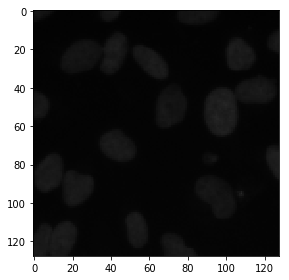

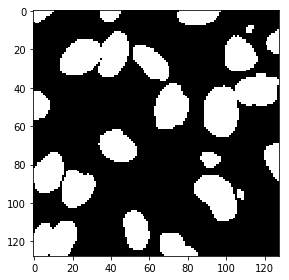

/home/deraso/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


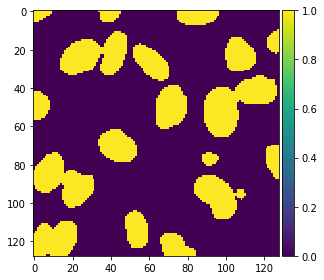

In [12]:

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


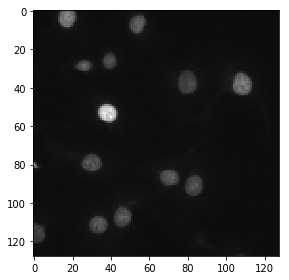

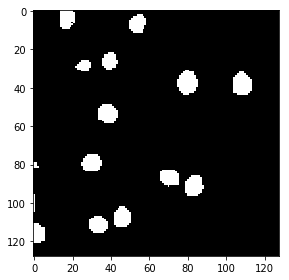

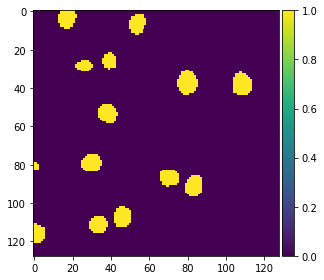

In [13]:

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [16]:
'''
Encode results for submission
'''

import pandas as pd
from skimage.morphology import label

# Run-length encoding 
# from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
'''
Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage
'''
        
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    

'''
Create submission DataFrame
'''

sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('nuclei_finder_bench1_deraso.csv', index=False)

# Scores 0.261